# Imports

In [1]:
import sys, os
# from scipy.stats import norm

In [2]:
sys.path.append(os.path.abspath(os.path.join('../utils')))
from ordinal_model.ordered_gaussian import OrderedGaussian
from ordinal_model.ordinal_regression_TF import OrdinalRegression
from ordinal_model.ordinal_regression_TF import OrdinalLoss

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

In [4]:
# sys.path.append(os.path.abspath(os.path.join('../utils')))
# from ordinal_model.OrdinalRegression import OrdinalRegression, softplus, softplus_inv, plot_model
# import autograd.numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Tensor Flow Probability Testing

In [14]:
dist = OrderedGaussian(cutpoints=[-2., 0, 2], loc=[0,1,2])
dist.ordinal_probs()

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[2.2750132e-02, 4.7724986e-01, 4.7724983e-01, 2.2750139e-02],
       [1.3498989e-03, 1.5730536e-01, 6.8268949e-01, 1.5865529e-01],
       [3.1671265e-05, 2.2718463e-02, 4.7724986e-01, 5.0000000e-01]],
      dtype=float32)>

In [16]:
dist.batch_shape

TensorShape([3])

In [17]:
loss = OrdinalLoss()
loss([0,0,0], dist)

<tf.Tensor: shape=(), dtype=float32, numpy=6.9170036>

In [18]:
dist2 = tfp.distributions.OrderedLogistic(cutpoints=[-2., 0, 2], loc=[0., 1., 2.])
dist2.categorical_probs()

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0.11920291, 0.38079712, 0.3807971 , 0.11920291],
       [0.04742587, 0.22151555, 0.46211717, 0.26894143],
       [0.01798621, 0.10121672, 0.38079712, 0.5       ]], dtype=float32)>

In [19]:
dist2.batch_shape

TensorShape([3])

# Ordinal Regression Testing

## Sequence State 2--Gaussian perfect separation

### Toy Data

In [15]:
state_2_df = pd.read_csv('../toydata/simulated_data/features_from_state2.csv', 
                         dtype={'temperature_1' : np.float32, 
                                'temperature_2' : np.float32, 
                                'ordinal_label' : np.int32},
                    )
state_2_df

,temperature_1,temperature_2,ordinal_label
0,13.446886,-0.552414,1
1,12.467339,-0.456510,1
2,12.240645,1.487031,3
3,12.920970,1.347114,3
4,12.365956,-0.505576,1
...,...,...,...
995,13.299201,-1.777017,0
996,12.508565,1.482781,3
997,12.692524,0.986925,2
998,12.897209,-0.374903,1


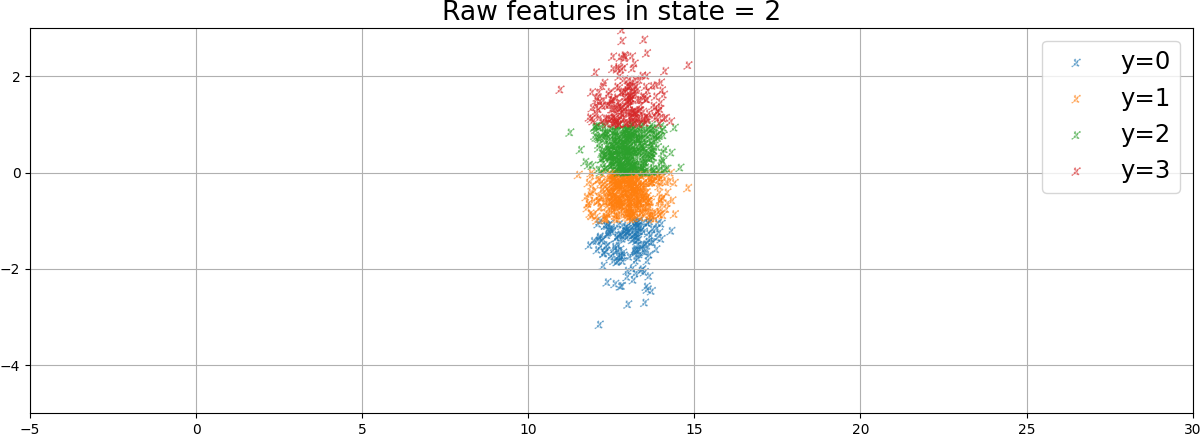

In [16]:
from IPython.display import Image
Image(filename='../toydata/simulated_data/features_from_state_2.png') 

In [17]:
# scaler = MinMaxScaler()
# X = scaler.fit_transform(state_2_df[['temperature_1', 'temperature_2']].values)
X = state_2_df[['temperature_1', 'temperature_2']].values
y = state_2_df['ordinal_label'].values
print(f'X: {X.shape}')
print(X)
print(f'y: {y.shape}')
print(y)

X: (1000, 2)
[[13.446886   -0.5524145 ]
 [12.467339   -0.45650953]
 [12.240645    1.4870306 ]
 ...
 [12.692524    0.9869254 ]
 [12.897209   -0.37490278]
 [14.0738535   1.120598  ]]
y: (1000,)
[1 1 3 3 1 2 2 1 0 1 2 1 1 2 1 3 2 2 1 0 0 2 2 1 2 1 1 0 2 2 0 0 2 2 1 2 0
 2 2 2 1 3 0 1 1 0 3 1 3 1 3 1 0 2 1 2 2 1 2 2 2 1 3 2 1 0 0 1 1 1 3 1 1 1
 0 2 1 1 2 3 1 2 2 1 2 2 3 1 0 1 0 1 1 2 2 0 0 0 1 2 2 2 2 2 1 0 2 1 3 2 1
 2 3 1 3 3 2 2 0 2 2 0 3 1 3 1 2 1 0 1 2 1 1 2 0 2 2 2 2 1 2 2 1 1 1 3 3 1
 3 3 3 0 2 2 2 2 2 0 2 2 2 0 2 2 2 2 1 1 1 1 2 1 1 2 3 3 0 1 2 2 0 2 0 2 2
 2 2 1 1 2 3 2 1 1 0 1 2 2 2 0 1 2 0 1 2 2 1 1 2 1 2 3 0 1 3 2 0 2 1 1 0 2
 3 2 1 2 3 2 3 3 2 1 1 3 3 1 0 2 1 2 1 1 1 3 1 2 3 2 1 3 1 3 0 1 3 2 0 1 3
 1 3 2 3 0 2 2 1 1 1 1 3 2 1 2 2 1 3 3 2 2 2 1 3 1 0 1 2 1 3 2 1 2 3 0 3 2
 3 2 1 2 1 0 1 2 0 2 1 2 1 2 1 2 2 2 3 2 1 1 1 0 3 2 2 2 1 3 2 0 2 1 3 2 3
 1 1 3 3 1 0 3 2 1 0 2 2 1 3 2 2 2 3 3 3 2 0 2 1 3 1 0 3 1 1 1 2 1 2 0 3 2
 1 3 0 3 3 2 3 1 2 3 2 2 2 1 1 1 3 0 0 2 2 1 0 2 2 3 2 2 0

In [18]:
# X = (X - X.mean(axis=0)) / X.std(axis=0)
# X

## Model

In [13]:
clf = OrdinalRegression()
clf.fit(X, y, use_gradient_tape=True, epochs=200, learning_rate=1e-3)
# proba = clf.predict_proba(X)
# y_predict = clf.predict(X)
# print(proba)
# print(y_predict)


Start of epoch 0
LOGITS:
tfp.distributions.OrderedLogistic("sequential_distribution_lambda_OrderedLogistic", batch_shape=[1000, 1], event_shape=[], dtype=int32)
Training loss (for one batch) at step 0: 2.1200
Seen so far: 1000 samples

Start of epoch 1
LOGITS:
tfp.distributions.OrderedLogistic("sequential_distribution_lambda_OrderedLogistic", batch_shape=[1000, 1], event_shape=[], dtype=int32)
Training loss (for one batch) at step 0: 2.0789
Seen so far: 1000 samples

Start of epoch 2
LOGITS:
tfp.distributions.OrderedLogistic("sequential_distribution_lambda_OrderedLogistic", batch_shape=[1000, 1], event_shape=[], dtype=int32)
Training loss (for one batch) at step 0: 2.0414
Seen so far: 1000 samples

Start of epoch 3
LOGITS:
tfp.distributions.OrderedLogistic("sequential_distribution_lambda_OrderedLogistic", batch_shape=[1000, 1], event_shape=[], dtype=int32)
Training loss (for one batch) at step 0: 2.0073
Seen so far: 1000 samples

Start of epoch 4
LOGITS:
tfp.distributions.OrderedLogis

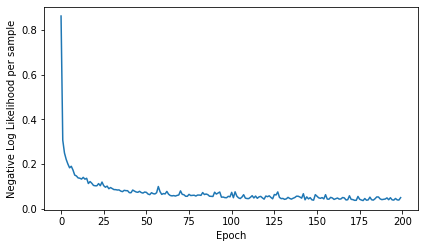

In [20]:
clf.plot_losses(flatten_epochs=True)

In [15]:
clf.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 3         
_________________________________________________________________
distribution_lambda_1 (Distr ((None, 1), (None, 1))    3         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [16]:
clf.model.trainable_variables

[<tf.Variable 'dense_1/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[nan],
        [nan]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32, numpy=array([nan], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([nan, nan, nan], dtype=float32)>]

In [23]:
y_predict = clf.predict(X)

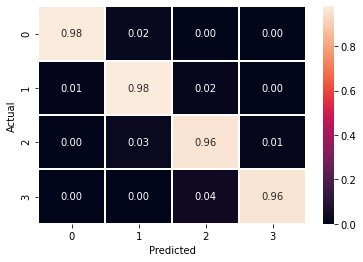

In [24]:
cf_matrix = confusion_matrix(y, y_predict, normalize='true',labels=list(range(y.max()+1))) 

ax = sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
plt.show()

In [ ]:
clf.grid_search_variance()

## Sequence State 2--Gaussian with label noise

### Toy Data

In [ ]:
state_2_with_noise_df = pd.read_csv('../toydata/simulated_data/features_from_state2_with_noise.csv')
state_2_with_noise_df

In [ ]:
from IPython.display import Image
Image(filename='../toydata/simulated_data/features_from_state2_with_noise.png') 

In [ ]:
# scaler = MinMaxScaler()
# X = scaler.fit_transform(state_2_df[['temperature_1', 'temperature_2']].values)
X = state_2_with_noise_df[['temperature_1', 'temperature_2']].values
y = state_2_with_noise_df['ordinal_label'].values
print(f'X: {X.shape}')
print(X)
print(f'y: {y.shape}')
print(y)

### Model

In [ ]:
clf = OrdinalRegression(noise_variance = None, C=1, save_loss=True, random_state=10)
clf.fit(X, y)
proba = clf.predict_proba(X)
y_predict = clf.predict(X)
print(proba)
print(y_predict)

In [ ]:
plot_model(clf)

In [ ]:
cf_matrix = confusion_matrix(y, y_predict, normalize='true',labels=list(range(y.max()+1))) 

ax = sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
plt.show()

## Crescent Shapes

### Toy Data

In [ ]:
cresent_df = pd.read_csv('../toydata/ordinal_data/crescent_shapes_4_labels.csv')
cresent_df

In [ ]:
from IPython.display import Image
Image(filename='../toydata/ordinal_data/crescent_shapes_4_labels.png') 

In [ ]:
# scaler = MinMaxScaler()
# X = scaler.fit_transform(state_2_df[['temperature_1', 'temperature_2']].values)
X = cresent_df[['x1', 'x2']].values
y = cresent_df['label'].values.astype(int)
print(f'X: {X.shape}')
print(X)
print(f'y: {y.shape}')
print(y)

### Model

In [ ]:
clf = OrdinalRegression(noise_variance = 1, C=1, save_loss=True, random_state=10)
clf.fit(X, y)
proba = clf.predict_proba(X)
y_predict = clf.predict(X)
print(proba)
print(y_predict)

In [ ]:
plot_model(clf)

In [ ]:
cf_matrix = confusion_matrix(y, y_predict, normalize='true',labels=list(range(y.max()+1))) 

ax = sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
plt.show()

## Concentric Circles

### Toy Data, Point Density Factor = 1

In [ ]:
circles_df = pd.read_csv('../toydata/ordinal_data/concentric_circles_4_labels_1.0_densityfactor.csv')
circles_df

In [ ]:
from IPython.display import Image
Image(filename='../toydata/ordinal_data/concentric_circles_4_labels_1.0_densityfactor.png') 

In [ ]:
# scaler = MinMaxScaler()
# X = scaler.fit_transform(state_2_df[['temperature_1', 'temperature_2']].values)
X = circles_df[['x1', 'x2']].values
y = circles_df['ordinal_label'].values
print(f'X: {X.shape}')
print(X)
print(f'y: {y.shape}')
print(y)

### Model

In [ ]:
clf = OrdinalRegression(noise_variance = 1, C=1, save_loss=True, random_state=10)
clf.fit(X, y)
proba = clf.predict_proba(X)
y_predict = clf.predict(X)
print(proba)
print(y_predict)

In [ ]:
plot_model(clf)

In [ ]:
cf_matrix = confusion_matrix(y, y_predict, normalize='true',labels=list(range(y.max()+1))) 

ax = sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
plt.show()

## Concentric Semi Circles

### Toy Data, Point Density Factor = 1

In [ ]:
semi_circles_df = pd.read_csv('../toydata/ordinal_data/concentric_semi_circles_4_labels_1_densityfactor.csv')
semi_circles_df

In [ ]:
from IPython.display import Image
Image(filename='../toydata/ordinal_data/concentric_semi_circles_4_labels_1_densityfactor.png') 

In [ ]:
# scaler = MinMaxScaler()
# X = scaler.fit_transform(state_2_df[['temperature_1', 'temperature_2']].values)
X = semi_circles_df[['x1', 'x2']].values
y = semi_circles_df['ordinal_label'].values
print(f'X: {X.shape}')
print(X)
print(f'y: {y.shape}')
print(y)

### Model

In [ ]:
clf = OrdinalRegression(noise_variance = 10, C=1, save_loss=True, random_state=10)
clf.fit(X, y)
proba = clf.predict_proba(X)
y_predict = clf.predict(X)
print(proba)
print(y_predict)

In [ ]:
plot_model(clf)

In [ ]:
cf_matrix = confusion_matrix(y, y_predict, normalize='true',labels=list(range(y.max()+1))) 

ax = sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
plt.show()

## Stacked Gaussians

### Toy Data, Point Density Factor = 1, Mean scale = 4

In [5]:
stacked_gaussian_df = pd.read_csv('../toydata/ordinal_data/stacked_gaussian_4_labels_1_densityfactor.csv')
stacked_gaussian_df

,x1,x2,ordinal_label
0,0.715279,1.883148,0
1,-0.008384,-2.185526,0
2,-0.720086,0.878702,0
3,0.108549,0.375490,0
4,-0.174600,0.006069,0
...,...,...,...
1995,1.150269,13.570840,3
1996,0.488751,12.953526,3
1997,-1.498064,12.627589,3
1998,1.287536,13.271711,3


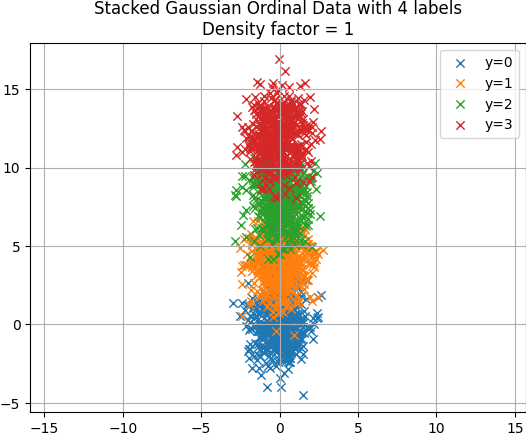

In [6]:
from IPython.display import Image
Image(filename='../toydata/ordinal_data/stacked_gaussian_4_labels_1_densityfactor.png') 

In [7]:
# scaler = MinMaxScaler()
# X = scaler.fit_transform(state_2_df[['temperature_1', 'temperature_2']].values)
X = stacked_gaussian_df[['x1', 'x2']].values
y = stacked_gaussian_df['ordinal_label'].values
print(f'X: {X.shape}')
print(X)
print(f'y: {y.shape}')
print(y)

X: (2000, 2)
[[ 7.15278974e-01  1.88314769e+00]
 [-8.38384993e-03 -2.18552605e+00]
 [-7.20085561e-01  8.78701761e-01]
 ...
 [-1.49806385e+00  1.26275894e+01]
 [ 1.28753594e+00  1.32717106e+01]
 [-5.48980805e-02  1.09671385e+01]]
y: (2000,)
[0 0 0 ... 3 3 3]


### Model

In [9]:
clf = OrdinalRegression(noise_variance = 1, C=1, save_loss=True, random_state=10)
clf.fit(X, y)
proba = clf.predict_proba(X)
y_predict = clf.predict(X)
print(proba)
print(y_predict)

ValueError: object arrays are not supported

In [16]:
log_proba = clf.predict_log_proba(X)
type(proba)

numpy.ndarray

In [19]:
logsumexp(log_proba, axis=1)

array([ 1.11022302e-16,  4.58617519e-17,  0.00000000e+00, ...,
        5.20417043e-18, -8.98261500e-17,  8.32667268e-17])

In [16]:
np.log(np.sum(proba, axis=1))

array([3.9999992e-07, 3.9999992e-07, 3.9999992e-07, ..., 3.9999992e-07,
       3.9999992e-07, 3.9999992e-07])

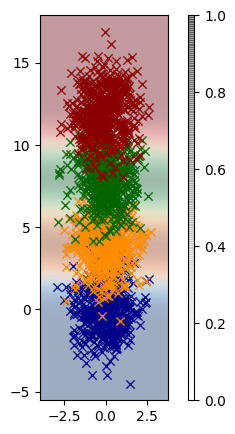

In [9]:
plot_model(clf)

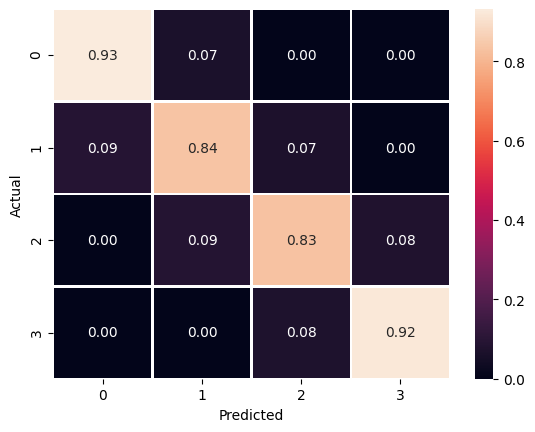

In [10]:
cf_matrix = confusion_matrix(y, y_predict, normalize='true',labels=list(range(y.max()+1))) 

ax = sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
plt.show()

In [ ]:
min_variance = clf.find_global_minimum_variance(iter=50)

### Toy Data, Point Density Factor = 0.5, Mean scale = 2

In [ ]:
stacked_gaussian_df = pd.read_csv('../toydata/ordinal_data/stacked_gaussian_4_labels_0.5_densityfactor_2_meanscale.csv')
stacked_gaussian_df

In [ ]:
from IPython.display import Image
Image(filename='../toydata/ordinal_data/stacked_gaussian_4_labels_0.5_densityfactor_2_meanscale.png') 

In [ ]:
# scaler = MinMaxScaler()
# X = scaler.fit_transform(state_2_df[['temperature_1', 'temperature_2']].values)
X = stacked_gaussian_df[['x1', 'x2']].values
y = stacked_gaussian_df['ordinal_label'].values
print(f'X: {X.shape}')
print(X)
print(f'y: {y.shape}')
print(y)

### Model

In [ ]:
clf = OrdinalRegression(noise_variance = 1, C=1, save_loss=True, random_state=10)
clf.fit(X, y)
proba = clf.predict_proba(X)
y_predict = clf.predict(X)
print(proba)
print(y_predict)

In [ ]:
plot_model(clf)

In [ ]:
cf_matrix = confusion_matrix(y, y_predict, normalize='true',labels=list(range(y.max()+1))) 

ax = sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
plt.show()

In [ ]:
min_variance = clf.find_global_minimum_variance()

In [ ]:
clf.grid_search_variance()

## Concentric Semi Circles

### Toy Data, Point Density Factor = 1

In [ ]:
semi_circles_df = pd.read_csv('../toydata/ordinal_data/concentric_semi_circles_4_labels_1_densityfactor.csv')
semi_circles_df

In [ ]:
from IPython.display import Image
Image(filename='../toydata/ordinal_data/concentric_semi_circles_4_labels_1_densityfactor.png') 

In [ ]:
# scaler = MinMaxScaler()
# X = scaler.fit_transform(state_2_df[['temperature_1', 'temperature_2']].values)
X = semi_circles_df[['x1', 'x2']].values
y = semi_circles_df['ordinal_label'].values
print(f'X: {X.shape}')
print(X)
print(f'y: {y.shape}')
print(y)

### Model

In [11]:
clf = OrdinalRegression(noise_variance = 1, C=1, save_loss=True, random_state=10)
clf.fit(X, y)
proba = clf.predict_proba(X)
y_predict = clf.predict(X)
print(proba)
print(y_predict)

ValueError: object arrays are not supported

In [ ]:
plot_model(clf)

In [ ]:
cf_matrix = confusion_matrix(y, y_predict, normalize='true',labels=list(range(y.max()+1))) 

ax = sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
plt.show()

# Misc. Testing

In [ ]:
X = np.array(
    [
        [-80,-90,-100],
        [4,5,6],
        [80,90,100],
        [-81,-93,-99],
        [4.2,5.1,6.3],
        [81,93,99],
        [-87,-94,-98],
        [4.1,5.2,6.5],
        [87,94,98],
    ]
)
y = np.array(
    [
        0,
        1,
        2,
        0,
        1,
        2,
        0,
        1,
        2,
    ]
)
w_inits = []
for i in range(100):
    w_inits.append(np.random.rand(3) * np.random.randint(0,10))

In [ ]:
clf = OrdinalRegression()
clf.set_params(R = 3, N = 3, cut_points  = np.array([-np.inf, -3, 3, np.inf]))

In [ ]:
# for w in w_inits:
#     print(clf.log_likelihood(w, X, y))

In [ ]:
clf.fit(X, y)

In [ ]:
best_w = clf.w

In [ ]:
clf.predict(X)

## Softplus

In [ ]:
test_arr = np.absolute(np.random.normal(size=3))
print(test_arr)
inverse_arr = softplus_inv(test_arr)
print(inverse_arr)
recovered = softplus(inverse_arr)
print(recovered)

In [ ]:
softplus_inv(0.5969)

In [ ]:
softplus(np.array([1,2,3]))

In [ ]:
arr = np.array([1,2,10, 50])

In [ ]:
arr.shape

In [ ]:
softplus(arr)

In [ ]:
np.array(1)[np.newaxis].shape